Number of qubits in circuit 16
Circuit depth: 16
The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


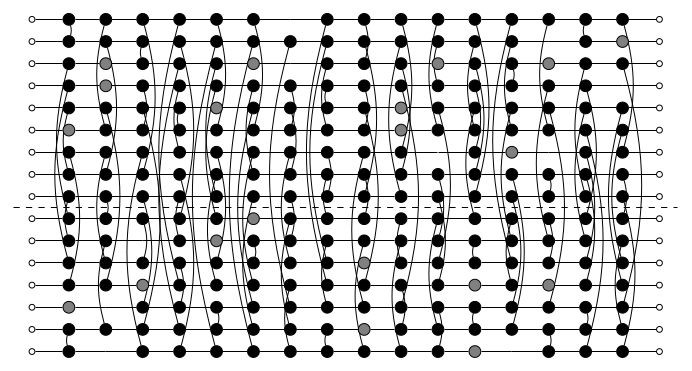

In [89]:
from qiskit.circuit.library import QFT, QuantumVolume
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile, QuantumCircuit
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork
from disqco.parti.FM.FM_methods import set_initial_partitions
import numpy as np

num_qubits = 16

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.9)

# circuit = QFT(num_qubits, do_swaps=False)

# circuit = QuantumVolume(num_qubits, depth=2)

# circuit = QuantumCircuit(num_qubits)

# circuit.cp(np.pi, 0, 1)
# circuit.cp(np.pi, 1, 2)
# circuit.cp(np.pi, 2, 3)

num_partitions = 2 # Define the number of partitions or QPUs you will distribute over


qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.

quantum_network = QuantumNetwork(qpu_sizes)


basis_gates = ['u', 'cp']
# basis_gates = ['h', 'rz', 'cx', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

depth = circuit.depth()

from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph

base_graph = QuantumCircuitHyperGraph(circuit, group_gates=False)

from disqco.drawing import tikz_drawing

%load_ext jupyter_tikz

fig = tikz_drawing.draw_graph_tikz(base_graph, set_initial_partitions(quantum_network, num_qubits, base_graph.depth), qpu_info=qpu_sizes)

display(fig)

In [90]:
from disqco.graphs.GCP_hypergraph_extended import HyperGraph, HyperEdge


graph = HyperGraph()

graph.convert_from_GCP(base_graph)

for node in graph.nodes():
    print(node)

Node:  (0, 0)
Node type:  two-qubit
Gate partner:  (1, 0)
Gate node does not exist:  (1, 0, 0)
Create gate node:  (0, 1, 0)
Edge attributes:  {'type': 'two-qubit', 'name': 'cp', 'params': [3.633772785066597]}
Group is not live on root:  0
Create new hyperedge:  set()
Added node to hyperedge:  (0, 0)
Added gate node to hyperedge:  (0, 1, 0)
Hyperedge:  {(0, 1, 0), (0, 0)}
Node:  (0, 1)
Node type:  two-qubit
Gate partner:  (5, 1)
Gate node does not exist:  (5, 0, 1)
Create gate node:  (0, 5, 1)
Edge attributes:  {'type': 'two-qubit', 'name': 'cp', 'params': [0.09039932213899227]}
Group is live on root:  0
Added node to hyperedge:  (0, 1)
Added gate node to hyperedge:  (0, 5, 1)
Hyperedge:  {(0, 1), (0, 5, 1), (0, 1, 0), (0, 0)}
Node:  (0, 2)
Node type:  two-qubit
Gate partner:  (7, 2)
Gate node does not exist:  (7, 0, 2)
Create gate node:  (0, 7, 2)
Edge attributes:  {'type': 'two-qubit', 'name': 'cp', 'params': [2.227948040661152]}
Group is live on root:  0
Added node to hyperedge:  (0,

In [91]:
import numpy as np

def set_initial_partitions_extended(network : QuantumNetwork, graph, num_qubits: int, depth: int, invert=False) -> list:
    static_partition = []
    qpu_info = network.qpu_sizes
    num_partitions = len(qpu_info)
    for n in range(num_partitions):
        for k in range(qpu_info[n]):
            if invert == False:
                static_partition.append(n)
            else:
                static_partition.append(num_partitions-n-1)
    static_partition = static_partition[:num_qubits]
    assignment = {}
    for i in range(depth):
        for j in range(num_qubits):
            assignment[(j,i)] = static_partition[j]
    
    for node in graph.nodes():
        if len(node) == 3:
            qubit_node1 = (node[0], node[2])
            assignment1 = assignment[qubit_node1]
            assignment[node] = assignment1
    return assignment
    

partition_assignment = set_initial_partitions_extended(quantum_network, graph, num_qubits, depth)

node_neighbors = {v: graph.neighbors(v) for v in graph.nodes()}
for node in graph.nodes():
    neighbors = node_neighbors[node]
    print(f"Node {node} has neighbors: {neighbors}")
    neighbors = graph.node_neighbours[node]


Node (0, 1, 0) has neighbors: {(0, 5, 10), (0, 5, 13), (1, 7, 1), (0, 12, 3), (1, 15, 5), (0, 2), (1, 2, 2), (0, 5), (1, 0), (1, 6), (0, 8), (0, 14), (1, 3), (1, 9), (0, 11), (0, 8, 11), (1, 12), (1, 8, 8), (1, 11, 7), (1, 15, 4), (0, 5, 1), (1, 5, 12), (0, 11, 12), (0, 1), (0, 7), (0, 1, 14), (1, 2), (0, 4), (0, 10), (1, 5), (1, 11), (0, 13), (1, 8), (1, 14), (1, 9, 3), (0, 5, 5), (0, 6, 9), (0, 7, 2), (1, 5, 11), (0, 12, 7), (0, 6, 15), (0, 0), (1, 13, 6), (1, 1), (0, 3), (0, 9), (1, 4), (0, 6), (0, 12), (1, 7), (1, 13), (0, 15), (1, 10), (1, 3, 10), (0, 2, 8), (1, 8, 9), (0, 5, 4)}
Node (0, 5, 1) has neighbors: {(0, 5, 10), (0, 5, 13), (0, 1, 0), (3, 5, 6), (0, 12, 3), (5, 4), (5, 1), (5, 7), (2, 5, 7), (0, 2), (4, 5, 3), (0, 5), (0, 8), (0, 14), (0, 11), (0, 8, 11), (3, 5, 2), (3, 5, 8), (5, 6), (5, 3), (0, 11, 12), (0, 1), (0, 7), (0, 1, 14), (0, 4), (0, 10), (0, 13), (0, 5, 5), (0, 6, 9), (0, 7, 2), (5, 2), (0, 12, 7), (0, 6, 15), (5, 5), (0, 0), (5, 8), (0, 3), (0, 9), (0, 6), (

In [92]:
import copy

def get_edge_count(graph : HyperGraph, edge : HyperEdge, partition_assignment, num_partitions):
    counts = np.zeros(num_partitions)
    nodes_in_edge = edge.vertices
    for node in nodes_in_edge:
        counts[partition_assignment[node]] += 1
    return counts

def config_from_counts(counts):
    config = np.zeros(counts.shape)
    for i in range(len(counts)):
        if counts[i] > 0:
            config[i] = 1
    return config

def get_edge_config(graph : HyperGraph, edge : HyperEdge, partition_assignment, num_partitions):
    counts = get_edge_count(graph, edge, partition_assignment, num_partitions)

    config = config_from_counts(counts)
    return config

def calculate_full_cost(graph : HyperGraph, partition_assignment, num_partitions):
    full_cost = 0
    for edge in graph.hyperedges():
        print(f'Edge info {edge}')
        config = get_edge_config(graph, edge, partition_assignment, num_partitions)
        print(f'Config {config}')
        cost = np.sum(config) - 1
        print(f'Cost {cost}')
        full_cost += cost
    return full_cost

def assign_counts_and_config(graph : HyperGraph, edge : HyperEdge, partition_assignment, num_partitions):
    counts = get_edge_count(graph, edge, partition_assignment, num_partitions)
    config = config_from_counts(counts)
    edge_key = edge.key

    graph.set_hyperedge_attrs(edge_key, attr_key='counts', attr = counts)
    graph.set_hyperedge_attrs(edge_key, attr_key='config', attr = config)
    graph.set_hyperedge_attrs(edge_key, attr_key='cost', attr = np.sum(config) - 1)



def calculate_gain(counts, config, source, destination):
    counts[source] -= 1
    counts[destination] += 1
    net_gain = 0
    if counts[source] == 0:
        config[source] = 0
        net_gain -= 1
    if counts[destination] == 1:
        config[destination] = 1
        net_gain += 1
        
    return net_gain, counts, config

def assign_all_counts_and_configs(graph : HyperGraph, partition_assignment, num_partitions):
    for edge in graph.hyperedges():
        assign_counts_and_config(graph, edge, partition_assignment, num_partitions)

def find_gain(graph : HyperGraph, node, source, destination):
    
    incident_edges = graph.incident(node)
    gain = 0
    print(f'Finding gain for {node} moving from {source} to {destination}')
    for edge in incident_edges:
        counts = graph.get_hyperedge_attrs(edge, 'counts').copy()
        config = graph.get_hyperedge_attrs(edge, 'config').copy()  

        contrib_gain, new_counts, new_config = calculate_gain(counts, config, source, destination)
        gain += contrib_gain
    # print(f'Total gain {gain}')
    return gain

def find_gain_raw(graph : HyperGraph, node, partition_assignment, destination):
    
    incident_edges = graph.incident(node)
    gain = 0
    for edge_key in incident_edges:
        working_assignment = copy.deepcopy(partition_assignment)
        edge = graph._hyperedges[edge_key]
        config1 = get_edge_config(graph, edge, working_assignment, num_partitions) 
        cost1 = np.sum(config1) - 1
        working_assignment[node] = destination
        config2 = get_edge_config(graph, edge, working_assignment, num_partitions)
        cost2 = np.sum(config2) - 1
        gain += cost2 - cost1

    # print(f'Total gain {gain}')
    return gain


def find_all_gains(graph : HyperGraph, partition_assignment, num_partitions, locked = set()):
    gain_dict = {}
    for node in set(graph.nodes()) - locked:
        source = partition_assignment[node]
        destinations = set(range(num_partitions)) - {source}
        
        for i in range(num_partitions):
            if i == source:
                continue
            gain = find_gain_raw(graph, node, partition_assignment, i)
            gain_dict[(node, i)] = gain
    return gain_dict

def find_spaces(graph : HyperGraph, partition_assignment, depth, qpu_sizes):
    spaces = np.array([qpu_sizes.copy() for _ in range(depth)])
    for node in graph.nodes():
        if is_gate_node(node):
            continue
        t = node[1]
        k = partition_assignment[node]
        spaces[t][k] -= 1
    return spaces

def is_gate_node(node):
    if len(node) == 3:
        return True
    return False

def is_valid(action, node, spaces):
    node = action[0]
    if is_gate_node(node):
        return True
    destination = action[1]
    time = node[1]
    if spaces[time][destination] == 0:
        return False
    else:
        return True

def choose_action(buckets, partition_assignment, graph, locked, max_gain, spaces):
    for i in range(-max_gain, max_gain+1):
        action_set = buckets.get(i, set([]))
        for action in action_set:
            node = action[0]
            if is_valid(action, partition_assignment, spaces) and node not in locked:
                gain = i
                action_set.remove(action)
                return action, gain
    return None


                    
def take_action_and_update(graph, action, partition_assignment, gain_dict, buckets, locked):
    node = action[0]
    destination = action[1]
    source = partition_assignment[node]
    locked.add(node)
    updates = {}
    edges = graph.incident(node)
    print(f'Updating for {node} moving from {source} to {destination}')
    for edge_key in graph.incident(node):
        print(f'Edge {edge_key}')
        edge = graph._hyperedges[edge_key]
        counts = graph.get_hyperedge_attrs(edge_key, 'counts')
        config = graph.get_hyperedge_attrs(edge_key, 'config')

        old_gain_contrib, new_counts, new_config = calculate_gain(counts.copy(), config.copy(), source, destination)
        nodes_to_update = edge.vertices - locked
        print(f'Nodes to update {nodes_to_update}')
        for next_node in nodes_to_update:
            for next_destination in range(num_partitions):
                if (next_node, next_destination) not in gain_dict:
                    continue

                next_node_source = partition_assignment[next_node]
                gain_contrib, _, _ = calculate_gain(new_counts.copy(), new_config.copy(), next_node_source, next_destination)

                if (next_node, next_destination) not in updates:
                    updates[(next_node, next_destination)] = 0
                
                updates[(next_node, next_destination)] += gain_contrib


        graph.set_hyperedge_attrs(edge_key, attr_key='counts', attr=new_counts)
        graph.set_hyperedge_attrs(edge_key, attr_key='config', attr=new_config)
        graph.set_hyperedge_attrs(edge_key, attr_key='cost', attr=np.sum(new_config) - 1)

    partition_assignment[node] = destination


    for node, destination in updates:
        old_gain = gain_dict[(node, destination)]
        new_gain = updates[(node, destination)]

        buckets[old_gain].remove((node, destination))
        buckets[new_gain].add((node, destination))

        gain_dict[(node, destination)] = new_gain

    return gain_dict, buckets

def take_action_and_update_neighbours(graph, action, partition_assignment, gain_dict, buckets, locked):
    node = action[0]
    destination = action[1]
    source = partition_assignment[node]
    locked.add(node)
    neighbours = graph.node_neighbours[node]
    partition_assignment[node] = destination
    # print(f'Updating for {node} moving from {source} to {destination}')
    # print(f'Neighbours to update {neighbours}')

    # for edge_key in graph.incident(node):
    #     counts = graph.get_hyperedge_attrs(edge_key, 'counts')
    #     config = graph.get_hyperedge_attrs(edge_key, 'config')
    #     old_gain_contrib, new_counts, new_config = calculate_gain(counts.copy(), config.copy(), source, destination)
    #     graph.set_hyperedge_attrs(edge_key, attr_key='counts', attr=new_counts)
    #     graph.set_hyperedge_attrs(edge_key, attr_key='config', attr=new_config)
    #     graph.set_hyperedge_attrs(edge_key, attr_key='cost', attr=np.sum(new_config) - 1)
    for neighbour in neighbours:
        for destination in range(num_partitions):
            # print(f'Checking {neighbour} moving from {partition_assignment[neighbour]} to {destination}')
            if (neighbour, destination) not in gain_dict or neighbour in locked:
                # print(f'Not in gain dict')
                continue
            # print(f'Updating for {neighbour}')
            old_gain = gain_dict[(neighbour, destination)]
            # print(f'Old gain {old_gain}')
            gain = find_gain_raw(graph, neighbour, partition_assignment, destination)
            # print(f'New gain {gain}')
            gain_dict[(neighbour, destination)] = gain
            buckets[old_gain].remove((neighbour, destination))
            buckets[gain].add((neighbour, destination))
    
    for k in range(num_partitions):
        if (node, k) in gain_dict:
            old_gain = gain_dict[(node, k)]
            if (node, k) in buckets[old_gain]:
                buckets[old_gain].remove((node, k))
            del gain_dict[(node, k)]

    return gain_dict, buckets


def update_spaces(node, source, destination, spaces):
    if is_gate_node(node):
        return spaces
    t = node[1]
    spaces[t][source] += 1
    spaces[t][destination] -= 1
    return spaces


In [93]:
from typing import Hashable, Iterable
# ----------------- helpers -----------------
def _build_buckets(gain_dict: dict[tuple[Hashable, int], int],
                   max_gain: int
) -> dict[int, set[tuple[Hashable, int]]]:
    """
    Gain → { (node, destination), … } map.
    """
    buckets = {g: set() for g in range(-max_gain, max_gain + 1)}
    for action, g in gain_dict.items():
        if -max_gain <= g <= max_gain:
            buckets[g].add(action)
    return buckets

def check_counts(graph, partition_assignment, num_partitions):
    for edge in graph.hyperedges():
        edge_key = edge.key
        counts = graph.get_hyperedge_attrs(edge_key, 'counts')
        counts_actual = get_edge_count(graph, edge, partition_assignment, num_partitions)
        if not np.array_equal(counts, counts_actual):
            print(f'Counts do not match for edge {edge}')
            print(f'Counts: {counts}, Actual counts: {counts_actual}')
            return False
    return True

def check_gains(graph, partition_assignment, num_partitions, gain_dict):
    for action, gain in gain_dict.items():
        node = action[0]
        destination = action[1]
        source = partition_assignment[node]
        gain_actual = find_gain_raw(graph, node, partition_assignment, destination)
        if gain != gain_actual:
            print(f'Gain does not match for action {action}')
            print(f'Gain: {gain}, Actual gain: {gain_actual}')
            raise ValueError(f'Gain does not match for action {action}')
            return False
    return True





def _unlock_all(graph: HyperGraph) -> set:
    """Handy shortcut instead of the old lock‑dict."""
    return set()
# --------------------------------------------


def FM_pass(graph: HyperGraph,
            max_gain: int,
            assignment: np.ndarray,
            qpu_sizes,
            limit: int,
            active_nodes: Iterable[Hashable] | None = None
):
    """
    One Kernighan–Lin / Fiduccia–Mattheyses pass on *graph*.
    Mirrors the original logic but uses the new gain‑/cost API.
    """
    if active_nodes is None:
        active_nodes = list(graph)                   # all vertices

    num_partitions = len(qpu_sizes if isinstance(qpu_sizes, (list, tuple)) else list(qpu_sizes.values()))

    # --- initial bookkeeping on edges --------------------------------
    # assign_all_counts_and_configs(graph, assignment, num_partitions)
    locked      = _unlock_all(graph)
    
    gain_dict = find_all_gains(graph, assignment, num_partitions, locked)
    buckets   = _build_buckets(gain_dict, max_gain)
    spaces    = find_spaces(graph, assignment, depth, qpu_sizes)

    # print(f'Initial assignment: {assignment}')
    # print(f'Spaces: {spaces}')

    # --- iterative improvement ---------------------------------------
    locked      = _unlock_all(graph)
    cum_gain    = 0
    gain_list   = [0]
    assign_hist = [assignment.copy()]

    h = 0
    while h < limit:

        out = choose_action(buckets, assignment, graph, locked,
                                     max_gain, spaces)
        if out is None:
            break
        action, gain = out
        # print(f'Action: {action}, gain: {gain}')
        if action is None:                          # nothing movable
            break

        # for node in assignment:
        #     print(f'Node {node} is in partition {assignment[node]}')

        node, dest           = action
        src                  = assignment[node]
        cum_gain            += gain

        # print(f'Node {node} is moving from {src} to {dest}')

        locked.add(node)
        assignment[node]     = dest                 # mutate in‑place

        gain_dict, buckets   = take_action_and_update_neighbours(
                                    graph, action, assignment,
                                    gain_dict, buckets, locked
                               )
        
        # print(check_counts(graph, assignment, num_partitions))

        # print(check_gains(graph, assignment, num_partitions, gain_dict))
        

        
        # assign_all_counts_and_configs(graph, assignment, num_partitions)
        # gain_dict = find_all_gains(graph, assignment, num_partitions, locked)
        # buckets   = _build_buckets(gain_dict, max_gain)
        
        update_spaces(node, src, dest, spaces)
        # print(f'Updated spaces: {spaces}')
        gain_list.append(cum_gain)
        assign_hist.append(assignment.copy())
        h += 1

    return assign_hist, gain_list


def run_FM(graph: HyperGraph,
           initial_assignment: np.ndarray,
           qpu_info,
           *,
           passes: int = 10,
           max_gain: int = 4,
           limit: int | None = None,
           stochastic: bool = True,
           log: bool = False,
           add_initial: bool = False,
):
    """
    Multi‑pass FM optimiser (rewritten for the new edge‑cost API).
    """
    if isinstance(qpu_info, dict):
        qpu_sizes = [list(qpu_info.values())]
    else:
        qpu_sizes = qpu_info                              # list or list[list]

    num_partitions = len(qpu_sizes if isinstance(qpu_sizes, (list, tuple)) else list(qpu_sizes.values()))
    # initial_assignment = np.asarray(initial_assignment, dtype=int)
    
    if limit is None:
        limit = graph.node_count           # 12.5 % of vertices

    best_assignments: list[np.ndarray] = []
    cost_trace:       list[int]        = []

    if add_initial:
        cost0 = calculate_full_cost(graph, initial_assignment, num_partitions)
        best_assignments.append(initial_assignment.copy())
        cost_trace.append(cost0)
        if log:
            print("Initial cost:", cost0)

    current_assign = initial_assignment.copy()
    current_cost   = calculate_full_cost(graph, current_assign, num_partitions)

    for p in range(passes):
        assigns, gains = FM_pass(graph, max_gain, current_assign.copy(),
                                 qpu_sizes, limit)
        if stochastic:
            if p & 1:                         # odd → exploit
                idx = int(np.argmin(gains))
            else:                             # even → explore
                idx = -1
        else:
            idx = int(np.argmin(gains))

        current_assign = assigns[idx].copy()
        current_cost  += gains[idx]

        best_assignments.append(current_assign.copy())
        cost_trace.append(current_cost)

        if log:
            print(f"Pass {p:2d}: cost = {current_cost}")

    # ---------------- result -----------------
    best_idx   = int(np.argmin(cost_trace))
    return cost_trace[best_idx], best_assignments[best_idx], cost_trace

print('Initial assignment:', partition_assignment)
print('Initial cost:', calculate_full_cost(graph, partition_assignment, num_partitions))

qubit_assignment = np.zeros((depth,num_qubits))

for i in range(depth):
    for j in range(num_qubits):
        qubit_assignment[i][j] = partition_assignment[(j,i)]

print(qubit_assignment)

Initial assignment: {(0, 0): 0, (1, 0): 0, (2, 0): 0, (3, 0): 0, (4, 0): 0, (5, 0): 0, (6, 0): 0, (7, 0): 0, (8, 0): 0, (9, 0): 1, (10, 0): 1, (11, 0): 1, (12, 0): 1, (13, 0): 1, (14, 0): 1, (15, 0): 1, (0, 1): 0, (1, 1): 0, (2, 1): 0, (3, 1): 0, (4, 1): 0, (5, 1): 0, (6, 1): 0, (7, 1): 0, (8, 1): 0, (9, 1): 1, (10, 1): 1, (11, 1): 1, (12, 1): 1, (13, 1): 1, (14, 1): 1, (15, 1): 1, (0, 2): 0, (1, 2): 0, (2, 2): 0, (3, 2): 0, (4, 2): 0, (5, 2): 0, (6, 2): 0, (7, 2): 0, (8, 2): 0, (9, 2): 1, (10, 2): 1, (11, 2): 1, (12, 2): 1, (13, 2): 1, (14, 2): 1, (15, 2): 1, (0, 3): 0, (1, 3): 0, (2, 3): 0, (3, 3): 0, (4, 3): 0, (5, 3): 0, (6, 3): 0, (7, 3): 0, (8, 3): 0, (9, 3): 1, (10, 3): 1, (11, 3): 1, (12, 3): 1, (13, 3): 1, (14, 3): 1, (15, 3): 1, (0, 4): 0, (1, 4): 0, (2, 4): 0, (3, 4): 0, (4, 4): 0, (5, 4): 0, (6, 4): 0, (7, 4): 0, (8, 4): 0, (9, 4): 1, (10, 4): 1, (11, 4): 1, (12, 4): 1, (13, 4): 1, (14, 4): 1, (15, 4): 1, (0, 5): 0, (1, 5): 0, (2, 5): 0, (3, 5): 0, (4, 5): 0, (5, 5): 0, (6,

In [94]:
cost, best_assignment, cost_trace = run_FM(graph, partition_assignment, qpu_sizes, passes=100, max_gain=4, limit=num_qubits*depth*0.125, stochastic=True, log=True)

Edge info HyperEdge(vertices={(0, 5, 10), (0, 1), (0, 7), (0, 1, 14), (0, 5, 13), (0, 4), (0, 1, 0), (0, 10), (0, 13), (0, 12, 3), (0, 2, 8), (0, 5, 5), (0, 2), (0, 5), (0, 6, 9), (0, 7, 2), (0, 8), (0, 14), (0, 11), (0, 12, 7), (0, 8, 11), (0, 6, 15), (0, 11, 12), (0, 0), (0, 3), (0, 9), (0, 6), (0, 12), (0, 15), (0, 5, 1), (0, 5, 4)}, key=((0, 0), (0, 15)), attrs={})
Config [1. 0.]
Cost 0.0
Edge info HyperEdge(vertices={(0, 1, 14), (1, 2), (1, 7, 1), (0, 1, 0), (1, 5), (1, 11), (1, 15, 5), (1, 8), (1, 14), (1, 9, 3), (1, 2, 2), (1, 0), (1, 6), (1, 3), (1, 9), (1, 5, 11), (1, 12), (1, 8, 8), (1, 13, 6), (1, 11, 7), (1, 1), (1, 4), (1, 15, 4), (1, 7), (1, 13), (1, 10), (1, 3, 10), (1, 5, 12), (1, 8, 9)}, key=((1, 0), (1, 14)), attrs={})
Config [1. 0.]
Cost 0.0
Edge info HyperEdge(vertices={(1, 14), (1, 15)}, key=((1, 14), (1, 15)), attrs={})
Config [1. 0.]
Cost 0.0
Edge info HyperEdge(vertices={(2, 9, 0), (2, 0)}, key=((2, 0), (2, 0)), attrs={})
Config [1. 0.]
Cost 0.0
Edge info HyperE

KeyboardInterrupt: 

In [ ]:
cost = calculate_full_cost(graph, best_assignment, num_partitions)
print(f'Final cost: {cost}')

Edge info HyperEdge(vertices={(0, 2), (0, 12, 9), (0, 1, 15), (0, 5), (0, 8), (0, 14), (0, 11), (0, 9, 7), (0, 9, 13), (0, 10, 8), (0, 5, 3), (0, 13, 4), (0, 15, 10), (0, 11, 0), (0, 11, 12), (0, 1), (0, 7), (0, 4), (0, 10), (0, 13), (0, 14, 11), (0, 4, 6), (0, 12, 1), (0, 0), (0, 3), (0, 9), (0, 9, 5), (0, 6), (0, 12), (0, 15), (0, 13, 2), (0, 13, 14)}, key=((0, 0), (0, 15)), attrs={})
Config [1. 0.]
Cost 0.0
Edge info HyperEdge(vertices={(1, 14, 13), (0, 1, 15), (1, 0), (1, 6), (1, 3), (1, 9), (1, 12, 12), (1, 12), (1, 15), (1, 10, 11), (1, 13, 1), (1, 2), (1, 2, 10), (1, 4, 7), (1, 5), (1, 11), (1, 8), (1, 14), (1, 5, 2), (1, 14, 8), (1, 5, 5), (1, 13, 0), (1, 2, 6), (1, 12, 4), (1, 1), (1, 13, 3), (1, 7, 14), (1, 4), (1, 7), (1, 13), (1, 10), (1, 8, 9)}, key=((1, 0), (1, 15)), attrs={})
Config [1. 0.]
Cost 0.0
Edge info HyperEdge(vertices={(2, 4), (2, 1), (2, 7), (2, 10, 3), (2, 9, 8), (2, 14, 2), (2, 2), (2, 5), (2, 8), (2, 15, 0), (1, 2, 6), (2, 0), (2, 11, 1), (2, 3), (2, 6), (2

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]
qubit_assignment [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0.

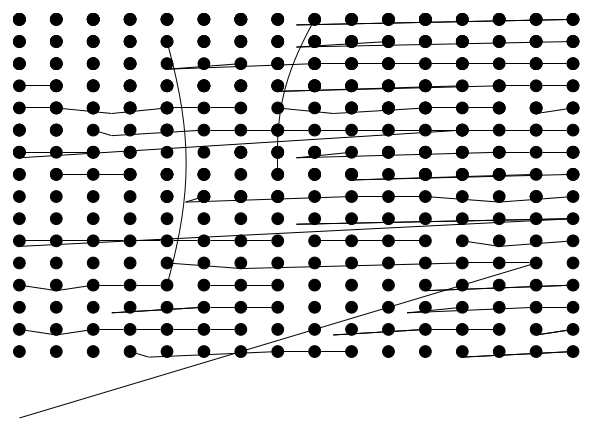

In [ ]:
from disqco.drawing.tikz_drawing import draw_graph_tikz_v2

qubit_assignment = np.zeros((depth,num_qubits))

for i in range(depth):
    for j in range(num_qubits):
        qubit_assignment[i][j] = best_assignment[(j,i)]

print(qubit_assignment)

fig = draw_graph_tikz_v2(graph, best_assignment, qpu_info=qpu_sizes, depth=depth, num_qubits=num_qubits)

display(fig)